In [62]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
import spacy
import pickle
import itertools
import seaborn as sns
import time
from tqdm import tqdm

## Use Spacy to vectorize lyrics

In [3]:
nlp = spacy.load('en_core_web_md')

In [6]:
tqdm.pandas()

/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [7]:
df['spacy'] = df.clean_lyrics.progress_apply(lambda x: nlp(x))

100%|██████████| 401817/401817 [2:36:00<00:00, 42.93it/s]  


In [8]:
#save dataframe with spacy column
df.to_csv('df_w_spacy.csv')

In [15]:
#get vector representation for lyrics utilizing spacy
spacy_df = pd.DataFrame(np.vstack([x.vector for x in df.spacy]))

In [16]:
#save dataframe in case of kernel failure
spacy_df.to_csv('spacy_df.csv')

## Load Dataframes

In [2]:
df = pd.read_csv('df_w_spacy.csv', index_col = 0)

In [3]:
spacy_df = pd.read_csv('spacy_df.csv', index_col = 0)

In [4]:
df.isnull().sum()

artist                   0
lyrics                   0
clean_lyrics             0
cleaned_lemmed_lyrics    0
genre                    0
lines                    0
num_lines                0
num_words                0
words_per_line           3
unique_words             0
explicit                 0
spacy                    0
dtype: int64

In [5]:
# drop rows we found to be null
df.drop([28525, 68974, 275556], inplace = True)

In [6]:
#drop same rows in spacy_df
spacy_df.drop([28525, 68974, 275556], inplace = True)

## Checking Class Balance

In [10]:
# check out the class balance
df['genre'].value_counts(normalize=True)

Pop/R&B         0.399202
Rock/Metal      0.288912
Hip-Hop/Rap     0.193134
Country/Folk    0.118751
Name: genre, dtype: float64

There is a bit of a class imbalance here, the Pop/R&B genre outweighs all other genres. We will downsample here for two reasons. First this will help alleviate the class imbalance issue and second it will help the models fit quicker as the decision tree/random forest took hours to fit to the training set with the full dataframe.

### StopWords

In [49]:
# create stopwords and update as spacy lemmatizer converts all pronouns (i, we, us, etc..) to -PRON-
stopwords_list = stopwords.words('english')+['pron', '-PRON-', 'br']
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Modeling

## Baseline

From checking our classes we have shown that our classes are a bit imbalanced. we will fit a dummy classifier to get a baseline model after downsampling our classes.

In [7]:
# set datframe for dummyclassifier
X = df

# Create target variable for dummyclassifier
y = df['genre']

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=333)

## Downsample training set

In [8]:
# set up dataframes by genre to downsample (we will downsample to size of Country_df)
Country_df = X_train[X_train['genre'] == 'Country/Folk']
Pop_df = X_train[X_train['genre'] == 'Pop/R&B']
Rock_df = X_train[X_train['genre'] == 'Rock/Metal']
Rap_df = X_train[X_train['genre'] == 'Hip-Hop/Rap']

In [9]:
# downsample pop genre
Pop_downsampled = resample(Pop_df,
                                replace = False, # sample without replacement
                                n_samples = len(Country_df), # match minority n
                                random_state = 333) # reproducible results

In [10]:
# downsample rep genre
Rap_downsampled = resample(Rap_df,
                                replace = False, # sample without replacement
                                n_samples = len(Country_df), # match minority n
                                random_state = 333) # reproducible results

In [11]:
# downsample rock genre
Rock_downsampled = resample(Rock_df,
                                replace = False, # sample without replacement
                                n_samples = len(Country_df), # match minority n
                                random_state = 333) # reproducible results

In [12]:
# combine dataframes for modeling
# combine minority and downsampled genres
downsampled = pd.concat([Pop_downsampled, Country_df, Rock_downsampled, Rap_downsampled])

### Fit dummy classifier

In [13]:
y_train = downsampled['genre']
X_train = downsampled.drop(['genre'], axis = 1)

In [27]:
# DummyClassifier to predict only most frequent class
dummy = DummyClassifier(strategy='uniform').fit(X_train, y_train)
dummy_pred_test = dummy.predict(X_test)

In [28]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(dummy_pred_test, y_test))
print()
# checking F1
print('Test F1 score: ', f1_score(dummy_pred_test, y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, dummy_pred_test))

Test Accuracy score:  0.25294164493200866

Test F1 score:  0.2419491157808375

Confusion matrix test set: 
 [[ 3148  3086  2935  2928]
 [ 4854  4895  4797  4845]
 [ 9920  9985 10090  9939]
 [ 7277  7185  7294  7276]]


this is will be our baseline model and what we will compare our models with

## TFIDF

In [42]:
X_train.reset_index(inplace = True, drop = True)

In [45]:
X_test.reset_index(inplace = True, drop = True)

In [ ]:
# vectorize our predictor column, n_gram range was chosen as we found having groups of words increased 
# our score, max_features of 50,000 was used as anything bigger than that kept making the kernel crash
vect = TfidfVectorizer(ngram_range=(1, 3), max_features = 50000, stop_words=stopwords)
    
#fit/transform train set and transform test set
X_train=vect.fit_transform(X_train['cleaned_lemmed_lyrics'])
X_test=vect.transform(X_test['cleaned_lemmed_lyrics'])
    
# make into a dataframe with the ngrams as column names
X_train = pd.DataFrame(X_train.toarray(), columns=vect.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=vect.get_feature_names())

### Naive Bayes no engineered features

In [16]:
%%time

#INSTANTIATE NB Classifier
Naive = MultinomialNB()

#fit to training set
Naive.fit(X_train,y_train)

#predict on train and test set
y_pred_nb_train = Naive.predict(X_train)
y_pred_nb_test = Naive.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_nb_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_nb_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_nb_train, y_train, average = 'weighted'))
print('Test F1 score: ', f1_score(y_pred_nb_test,y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_nb_test))

Train Accuracy score:  0.4817671221393243
Test Accuracy score:  0.43184675999664685

Train F1 score:  0.491709154534739
Test F1 score:  0.4411914505041779

Confusion matrix test set: 
 [[7167  949 1323 2369]
 [2673 4958 1684 2708]
 [3975 1629 2710 3562]
 [3380 1288 1570 5771]]
CPU times: user 1min 36s, sys: 2min 44s, total: 4min 20s
Wall time: 2min 40s


## Spacy

In [32]:
predictors = spacy_df
target = df['genre']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state=333)

In [34]:
# instantiate our scaler
scaler = MinMaxScaler()

# scale our engineered features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# turn the arrays into dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Naive Bayes no engineered features

In [35]:
%%time

#INSTANTIATE NB Classifier
Naive_sp = MultinomialNB()

#fit to training set
Naive_sp.fit(X_train_scaled,y_train)

#predict on train and test set
y_pred_nb_train = Naive_sp.predict(X_train_scaled)
y_pred_nb_test = Naive_sp.predict(X_test_scaled)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_nb_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_nb_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_nb_train, y_train, average = 'weighted'))
print('Test F1 score: ', f1_score(y_pred_nb_test,y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_nb_test))

Train Accuracy score:  0.39975776479957525
Test Accuracy score:  0.39753519023632705

Train F1 score:  0.5711813498770835
Test F1 score:  0.5689090235632674

Confusion matrix test set: 
 [[    0     0 12097     0]
 [    0     0 19391     0]
 [    0     0 39934     0]
 [    0     0 29032     0]]
CPU times: user 6.06 s, sys: 60 ms, total: 6.12 s
Wall time: 3.66 s


Naive Bayes model is just picking dominant class, we will need to choose a different model

## Decision Tree no engineered features

In [60]:
# look at cross validation scores to see if model should be fitted
# instantiate the decision tree classifier
tree = DecisionTreeClassifier(class_weight = 'balanced',random_state = 333)

# fit it to our training set and evaluate
cross_val_score(tree, X_train, y_train, cv=10, n_jobs=-1)

array([0.34656225, 0.34925007, 0.34845368, 0.35270109, 0.34705999,
       0.34755774, 0.35183833, 0.34908415, 0.34775684, 0.34905097])

Naive Bayes model performed better but it was just choosing dominant class so we will fit a model to see how it performs against random forest

In [61]:
%%time

# INSTANTIATE DECISION TREE MODEL
tree = DecisionTreeClassifier(class_weight = 'balanced',random_state = 333)

#fit to training set
tree.fit(X_train, y_train)

#predict on train and test set
y_pred_tree_train = tree.predict(X_train)
y_pred_tree_test = tree.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_tree_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_tree_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_tree_train, y_train, average = 'weighted'))
print('Test F1 score: ', f1_score(y_pred_tree_test,y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_tree_test))

Train Accuracy score:  0.9980023891691001
Test Accuracy score:  0.34803989885917935

Train F1 score:  0.9980020742469141
Test F1 score:  0.3476420776531958

Confusion matrix test set: 
 [[ 2315  1887  4705  3190]
 [ 2046  5669  6890  4786]
 [ 4895  7099 17067 10873]
 [ 3263  4749 11109  9911]]
CPU times: user 2min 57s, sys: 342 ms, total: 2min 57s
Wall time: 2min 57s


## Random Forest no engineered features

In [73]:
# look at cross validation scores to see if model should be fitted
#INSTANTIATE RANDOM FOREST MODEL
rfc = RandomForestClassifier(random_state = 333, class_weight='balanced', n_jobs = -1)

# fit it to our training set and evaluate
cross_val_score(rfc, X_train, y_train, cv=10, n_jobs=-1)

array([0.46047916, 0.46011415, 0.46519113, 0.46256968, 0.46077781,
       0.46084417, 0.46323334, 0.45918503, 0.46144147, 0.46220467])

this is performing better than decision tree so we will fit a model

In [108]:
%%time

#INSTANTIATE RANDOM FOREST MODEL
rfc = RandomForestClassifier(random_state = 333, class_weight='balanced', n_jobs = -1)

#fit to training set
rfc.fit(X_train, y_train)

#predict on train and test set
y_pred_rfc_train = rfc.predict(X_train)
y_pred_rfc_test = rfc.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_rfc_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_rfc_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_rfc_train, y_train, average = 'weighted'))
print('Test F1 score: ', f1_score(y_pred_rfc_test,y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_rfc_test))

Train Accuracy score:  0.9980521635253518
Test Accuracy score:  0.45825950186154857

Train F1 score:  0.9980519170157529
Test F1 score:  0.5017324435134211

Confusion matrix test set: 
 [[  967   458  9222  1450]
 [  230  5235 11603  2323]
 [  618  2174 31585  5557]
 [  363  1021 19401  8247]]
CPU times: user 23min 53s, sys: 8.4 s, total: 24min 2s
Wall time: 1min 42s


## Naive Bayes with engineered features

In [48]:
engineered = df.drop(columns = ['artist', 'lyrics', 'clean_lyrics', 'cleaned_lemmed_lyrics', 'lines', 'genre', 'spacy'])

In [49]:
predictors = pd.concat([spacy_df, engineered], axis = 1)
target = df['genre']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state=333)

In [51]:
# instantiate our scaler
scaler = MinMaxScaler()

# scale our engineered features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# turn the arrays into dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [40]:
%%time

#INSTANTIATE NB Classifier
Naive_sp_feat = MultinomialNB()

#fit to training set
Naive_sp_feat.fit(X_train_scaled,y_train)

#predict on train and test set
y_pred_nb_train_sp_feat = Naive_sp_feat.predict(X_train_scaled)
y_pred_nb_test_sp_feat = Naive_sp_feat.predict(X_test_scaled)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_nb_train_sp_feat, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_nb_test_sp_feat, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_nb_train_sp_feat, y_train, average = 'weighted'))
print('Test F1 score: ', f1_score(y_pred_nb_test_sp_feat,y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_nb_test_sp_feat))

Train Accuracy score:  0.39976108308999203
Test Accuracy score:  0.397555099846696

Train F1 score:  0.5711506158571471
Test F1 score:  0.5689058056767914

Confusion matrix test set: 
 [[    0     0 12097     0]
 [    0     2 19389     0]
 [    0     0 39934     0]
 [    0     0 29032     0]]
CPU times: user 6.02 s, sys: 36 ms, total: 6.05 s
Wall time: 3.55 s


In [44]:
cm = confusion_matrix(y_test, y_pred_nb_test_sp_feat)
classes = ['Country', 'Hip_Hop/Rap', 'Pop/R&B', 'Rock/Metal']

Confusion Matrix, without normalization
[[    0     0 12097     0]
 [    0     2 19389     0]
 [    0     0 39934     0]
 [    0     0 29032     0]]


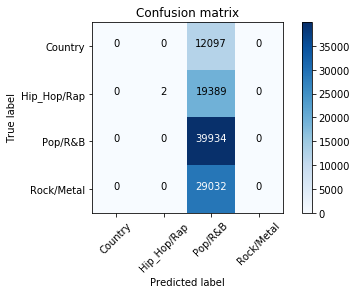

In [45]:
import itertools
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

for the most part this is still choosing dominant class with the exception of two instances we will move on to othe rmodel to see how they perform

## Decision Tree with engineered features

In [68]:
# look at cross validation scores to see if model should be fitted
# instantiate the decision tree classifier
tree_feat = DecisionTreeClassifier(class_weight = 'balanced',random_state = 333)

# fit it to our training set and evaluate
cross_val_score(tree_feat, X_train, y_train, cv=10, n_jobs=-1)

array([0.35611893, 0.3553889 , 0.36142819, 0.35744624, 0.35157287,
       0.35605256, 0.35890629, 0.35605256, 0.35472525, 0.35532254])

same as with our model without engineered features this model is performing worse than naive bayes but we will still fit a model as naive bayes is sticking to one class

In [52]:
%%time

# INSTANTIATE DECISION TREE MODEL
tree_feat = DecisionTreeClassifier(class_weight = 'balanced',random_state = 333)

#fit to training set
tree_feat.fit(X_train, y_train)

#predict on train and test set
y_pred_tree_train_feat = tree_feat.predict(X_train)
y_pred_tree_test_feat = tree_feat.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_tree_train_feat, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_tree_test_feat, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_tree_train_feat, y_train, average = 'weighted'))
print('Test F1 score: ', f1_score(y_pred_tree_test_feat,y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_tree_test_feat))

Train Accuracy score:  0.9987091850278736
Test Accuracy score:  0.3556453700201087

Train F1 score:  0.9987088634928497
Test F1 score:  0.35552055876365146

Confusion matrix test set: 
 [[ 2434  1809  4647  3207]
 [ 1928  5951  7039  4473]
 [ 4644  7002 17364 10924]
 [ 3354  4651 11050  9977]]
CPU times: user 3min 14s, sys: 646 ms, total: 3min 15s
Wall time: 3min 15s


## Random Forest with engineered features

In [69]:
# look at cross validation scores to see if model should be fitted
#INSTANTIATE RANDOM FOREST MODEL
rfc_feat = RandomForestClassifier(random_state = 333, class_weight='balanced', n_jobs = -1)

# fit it to our training set and evaluate
cross_val_score(rfc_feat, X_train, y_train, cv=10, n_jobs=-1)

array([0.46844306, 0.46738121, 0.47109769, 0.46691664, 0.46548978,
       0.4664189 , 0.46980356, 0.46535705, 0.46718211, 0.47156225])

this is performing better than decision tree so we will fit a model

In [55]:
%%time

#INSTANTIATE RANDOM FOREST MODEL
rfc_feat = RandomForestClassifier(random_state = 333, class_weight='balanced', n_jobs = -1)

#fit to training set
rfc_feat.fit(X_train, y_train)

#predict on train and test set
y_pred_rfc_train_feat = rfc_feat.predict(X_train)
y_pred_rfc_test_feat = rfc_feat.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_rfc_train_feat, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_rfc_test_feat, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_rfc_train_feat, y_train, average = 'weighted'))
print('Test F1 score: ', f1_score(y_pred_rfc_test_feat,y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_rfc_test_feat))

Train Accuracy score:  0.9986992301566233
Test Accuracy score:  0.4649491309455074

Train F1 score:  0.998698941067143
Test F1 score:  0.5032213259908189

Confusion matrix test set: 
 [[ 1173   477  8836  1611]
 [  264  5933 10942  2252]
 [  700  2454 31121  5659]
 [  444  1211 18898  8479]]
CPU times: user 24min 58s, sys: 8.01 s, total: 25min 6s
Wall time: 1min 48s


In [59]:
cm = confusion_matrix(y_test, y_pred_rfc_test_feat)
classes = ['Country', 'Hip_Hop/Rap', 'Pop/R&B', 'Rock/Metal']

Confusion Matrix, without normalization
[[ 1173   477  8836  1611]
 [  264  5933 10942  2252]
 [  700  2454 31121  5659]
 [  444  1211 18898  8479]]


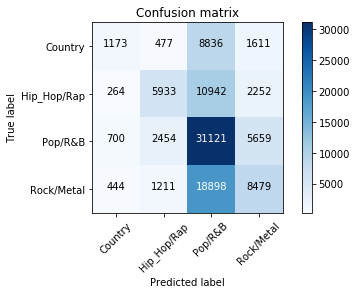

In [60]:
import itertools
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [63]:
# print out report
print(classification_report(y_test, y_pred_rfc_test_feat, target_names=list(target.unique())))

              precision    recall  f1-score   support

     Pop/R&B       0.45      0.10      0.16     12097
 Hip-Hop/Rap       0.59      0.31      0.40     19391
Country/Folk       0.45      0.78      0.57     39934
  Rock/Metal       0.47      0.29      0.36     29032

    accuracy                           0.46    100454
   macro avg       0.49      0.37      0.37    100454
weighted avg       0.48      0.46      0.43    100454



## Conclusion

Random Forest with engineered features is our best model, although not by a huge margin. Naive Bayes using Spacy vectorization seems to be just predicting the majority class in most cases. Naive Bayes TF-IDF Model is a good runner up but it as it does better than any of the decision trees models.